Este modelo de Machine Learning, se utilizara una red neuronal GAN en imagenes de anime

Para este modelo primero comenzaré con el dataset de MAL sin los usuarios ya que en el mismo estan los puntajes dados por ellos sin los los datos personales que no nos importarian mucho

## Librerias

In [1]:
import sys 
import os  # obtener el path del jupyter tenemos esto 
root_path = os.path.dirname(os.getcwd()) 
# ## os.chdir(os.path.dirname(__file__)) ## # usar solo este!!!!!!!!!!!!!1
root_path  
sys.path.append(root_path)  
sys.path
print('')

In [2]:
from Utils.Librerias import *
from Utils.Path import *
from Utils.Visualizacion import *
from Utils.Limpieza import *
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline

C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\jamr1\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


## GPU Activo?

In [3]:
print("Num GPUs Aviable: ", len(tf.config.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device:' .format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Num GPUs Aviable:  1
Default GPU Device:


In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

## Reshape images

In [6]:
st = time.time()

cwsinput = R'..\..\SRC\Data\Processed\128_128\*.jpg'
img_input_dir = cwsinput
files = glob(img_input_dir)
print(len(files))

cwdoutput = os.getcwd() + R'..\..\SRC\Data\Processed\128_2'
img_output_dir =cwdoutput
imagesize = (128,128)
for i,f1 in enumerate(files):
    startindex = f1.find(GANs)
    tempf1 = f1[startindex:]
    tempfn = img_output_dir + tempf1
    inputimage = cv2.imread(f1)
    sizedimage = cv2.resize(inputimage, imagesize)
    n = str(i) 
    cv2.imwrite(os.path.join(R'..\..\SRC\Data\Processed\128_2', ('image'+ n +'.png')), sizedimage)
    
print('The program took %s seconds' %(time.time()-st))

6592
The program took 17.033681869506836 seconds


## Data Load

A#adimos los datos en forma de numpy array

In [5]:
st = time.time()
cwdinput = R'..\..\SRC\Data\Processed\128_2\*.png'
img_input_dir = cwdinput
files = glob(img_input_dir)
print(len(files))


X_data = []
iterations = 0
for myFile in files:
    image = cv2.imread(myFile)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_data.append(image)
    iterations = iterations + 1
    if(iterations % 1000 == 0):
        print(iterations)
    if(iterations == 7000):
        break

X_data_array = np.asarray(X_data)
print('X_data shape: ', X_data_array.shape)

print('The program took %s seconds ' %(time.time()-st))

6592
1000
2000
3000
4000
5000
6000
X_data shape:  (6592, 128, 128, 3)
The program took 4.53963565826416 seconds 


save dataset

In [6]:
filename = '..\..\SRC\Model\Train_dataset_4.npz'
savez_compressed(filename, X_data_array)
print('Saved dataset: ', filename)

Saved dataset:  ..\..\SRC\Model\Train_dataset_4.npz


test dataset

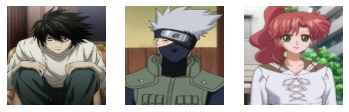

In [7]:
n_samples = 3

data = np.load('..\..\SRC\Model\Train_dataset_4.npz', allow_pickle=True)
train_images = data['arr_0']
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    plt.axis('off')
    plt.imshow(train_images[i].astype('uint8'))
plt.show();

In [8]:
print(len(train_images))

6592


In [9]:
train_images.shape

(6592, 128, 128, 3)

## Discriminator

In [10]:
def discriminator(in_shape=(128,128,3)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(256, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(512, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], run_eagerly=True)
	return model

## Generator

In [11]:
def generator(latent_dim):
    model = Sequential()
    n_nodes = 8 * 8 * 512
    model.add(Dense(n_nodes, input_dim = latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8,8,512)))
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


## Cuerpo

In [12]:
def add_to_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, run_eagerly=True)
    return model

In [13]:
def load_real_samples():
    X = data['arr_0']
    X = X.astype('float32')
    X = (X - 127.5) / 127.5
    return X

In [14]:
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    return X, y

In [15]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [16]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

In [17]:
def save_plot(examples, epoch, n=4):
    examples = (examples + 1) / 2.0
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i])
    filename = R'SRC\Notebooks\plot\img%03d.png' %(epoch+1)
    plt.savefig(filename)
    plt.close();

In [18]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, per_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, per_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('Accuracy real: %.0f%%, fake: %.0f%%' % (per_real*100, per_fake*100))
    save_plot(x_fake, epoch)
    filename = R'SRC\Notebooks\plot\model%03d.h5' %(epoch+1)
    g_model.save(filename)


In [19]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=32):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)    




In [23]:
def train2(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100000, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        if (i + 1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

## LLamada de la función

In [24]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = add_to_gan(g_model, d_model)
dataset = load_real_samples()
train2(g_model, d_model, gan_model, dataset, latent_dim)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
>1, 1/103, d1=0.684, d2=0.696 g=0.692
>1, 2/103, d1=0.516, d2=0.697 g=0.692
>1, 3/103, d1=0.316, d2=0.699 g=0.692
>1, 4/103, d1=0.121, d2=0.702 g=0.694
>1, 5/103, d1=0.029, d2=0.711 g=0.693
>1, 6/103, d1=0.012, d2=0.731 g=0.692
>1, 7/103, d1=0.005, d2=0.738 g=0.708
>1, 8/103, d1=0.009, d2=0.683 g=0.777
>1, 9/103, d1=0.009, d2=0.595 g=0.903
>1, 10/103, d1=0.015, d2=0.541 g=0.9

In [39]:
from keras import backend as K
K.clear_session()